# RADIAL BASIS FUNCTION SAMPLER, RBFSampler
This chapter continues off of 01-SVM and assumes you are familiar with SVMs and kernals.

## Kernel approximations

While kernels usually can increase models' predictability without sacrificing too much efficiency, this is not always true. For non-linear kernels like RBF the model complexity grows rapidly with the data size and amount, which makes the RBF kernel inadequate for our task.

Since our problem is both rich in features and observations we quickly run into long training times. With this, we lose the ability to find the most optimal hyperparameters. Kernal approximations would allow us to train much _much_ quicker, and thus can test a wider range of hyperparameters and combinations. You give up one thing, but gain another.

## The RBFSampler

Luckily there is a way to approximate the RBF kernel. This is done using random Fourier features. In sklearn this is implemented with a variant of Random Kitchen Sinks and the method is called RBFSampler.

The following images shows a single RBF (left) and a single RBFSampler (right). Not very similar!

Single RBF             |  Single RBFSampler
:-------------------------:|:-------------------------:
![](misc/rbf_single.png)  |  ![](misc/rbfsampler_single.png)

The beauty comes from combining several kernel/kernel approximations. Here are the same images with 20 combined:

20 RBFs combined             |  20 RBFSamplers combined
:-------------------------:|:-------------------------:
![](misc/rbf_multi.png)  |  ![](misc/rbfsampler_multi.png)


This is much closer! Note that these generated are completely randomly generated, so one should just focus on the structural similarities. They can become even more similar after training.


## The SGDClassifier

Using the RBFSampler in combination with a SGDClassifier we can approximate e.g. RBF-SVM (loss = 'hinge')  and an RBF-LogisticRegression (loss = 'log') very efficiently. There are even more possible losses. They are:

* _hinge_ --> linear SVM
* _log_ --> logistic regression
* _modified huber_ --> a smooth loss that brings tolerance to outliers as well as probability estimates
* _squared hinge_ --> like hinge but is quadratically penalized
* _perceptron_ --> linear loss used by the perceptron algorithm
* **regressions losses:** squared_error, huber, epsilon_insensitive, or squared_epsilon_insensitive


## Comment on Parameters
The SGDClassifier has three important parameters, _loss_ (discussed above), _penalty_ and _alpha_. The penalty has three options: 

_"Defaults to ‘l2’ which is the standard regularizer for linear SVM models. ‘l1’ and ‘elasticnet’ might bring sparsity to the model (feature selection) not achievable with ‘l2’."_

alpha is a float that is multiplied with the regularization term. The higher the value, the stronger the regularization.

Furthermore, for the RBFSampler there are two hyperparameters of interest. _gamma_ and _n-components_ which have an effect on the influence of single data points and how many Monte Carlo samples that are used per original feature.

All these parameters needs to be optimized.


# Preprocessing

Before training we need to import an pre-process the data. This is done with our self-developed python packages.

## Import internal utils

First we need to import our internal utils.

In [1]:
# Import the function that imports and pre-processes data
from utils.import_data import importData

# Import the class the tests ML-models
from utils.model_tester import ModelTester
import utils.nicer_plots

## Import the data

We're now ready to import the data. importData() imports the data from .csv-files and saves it into pandas dataFrames. It also performs a standardScaler, scaling the features one by one so their mean = 0 and std = 1.

In [2]:
# The name of the files to be imported
file_data = "data2.csv"
file_labels = "labels2.csv"

# How many of the 3851 features that should be selected (-1 <=> all)
n_features = -1

# The folder the files lies in
directory = "\data\\"

# Import the data
data, labels = importData(file_data, file_labels, directory, n_features, iterations=False)

Number of samples:    102400
Number of features:   3851


## Defining the model

#### [THIS PART IS VERY TECHINCAL AND CAN BE SKIPPED]
If you're not interested in how this is implemented, you can jump to **Model exploration**

With the data imported, we now need to define a new class, using both the SGDClassifier and the RBFSampler. This will make it possible to tune the parameters for the classifier and the sampler **at the same time**.

In [3]:
import numpy as np
from sklearn.linear_model import SGDClassifier

class RBFSamplerSVM():

    def __init__(self, penalty = 'l2', loss = 'hinge', tol = 1e-3, alpha = 0.0001, max_iter = 1000, gamma = 1, n_components = 100):
        self.SGD = SGDClassifier
        self.SGD_parameters = {
            'penalty': penalty,
            'loss': loss,       # hinge = SVM, log = LogistRegression
            'tol': tol,
            'alpha':alpha,
            'max_iter':max_iter}

        self.RBFSampler = RBFSampler
        self.RBFSampler_parameters = {
            'gamma': gamma,
            'n_components': n_components}

    def fit(self, x, y):
        # Fitting the features and the classifier
        # Initializing the RBFSampler
        self.rbf_features = self.RBFSampler(**self.RBFSampler_parameters)
        # Fitting and transforming the data
        x_features = self.rbf_features.fit_transform(x)
        # Initializing the SGDClassifier
        self.clf = self.SGD(**self.SGD_parameters)
        # Fit the data
        self.clf.fit(x_features, y)

    def predict(self, x):
        # Predicting labels
        y_pred = self.clf.predict(self.rbf_features.transform(x))
        return y_pred

    def predict_proba(self, x):
        # Predicting label scores
        y_scores = self.clf.predict_proba(self.rbf_features.transform(x))
        return y_scores

### Initializing the ModelTester

We're now ready to initialize a ModelTester object. Let's see if it works

In [4]:
# import model
from sklearn.kernel_approximation import RBFSampler

# initialize object
mt = ModelTester(data, labels, RBFSamplerSVM, gamma = 1, alpha = 0.001, loss = 'hinge') # everything after the model are the hyperparameters

# test to see that it was initialized correctly
RBFSampler_object = mt.model(**mt.parameters)
print(mt.parameters)
print(RBFSampler_object.SGD(**RBFSampler_object.SGD_parameters))
print(RBFSampler_object.RBFSampler(**RBFSampler_object.RBFSampler_parameters))

{'gamma': 1, 'alpha': 0.001, 'loss': 'hinge'}
SGDClassifier(alpha=0.001)
RBFSampler(gamma=1)


Seems like it worked!

### Custom functions

Since the SGD in the class we defined above only can return prediction scores for some losses, we need to create a dummy function that returns a vector of the correct size in some cases. This will render the AUC-score innacurate for incompaitble losses.

In [5]:
# uses predict_proba when loss is compatible
# otherwise returns zeros

def custom_predict_proba(self, x, model):
    
    if model.SGD_parameters['loss'] in ['log', 'modified_huber']:
        return model.predict_proba(x)[:, 1]

    else:    
        return np.zeros(x.shape[0])

In [6]:
# set the custom functiomn

mt.set_custom_functions(custom_predict_proba = custom_predict_proba)

# Model exploration

We're now ready to try the model out. We will split it into three sections

* A. Linear SVM (_hinge loss_)
* B. Logistic Regression (_log loss_)
* C. Remaining losses

Generally we will test the models by performing hyperparameter tuning (a grid search w. balanced accuracy) on the parameters _alpha_, _gamma_ and _n components_.

## A. Linear SVM

This combination, a RBFSampler and a SGDClassifier with a hinge loss, results in a Linear SVM with an approximated RBF-kernel. Let's run the tests.

In [7]:
# Model parameters
sampling = 'under'

# parameters that will be tested
parameters = {
            'loss':['hinge'],
            'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1],
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
            'n_components': [100, 200, 500, 1000]
        }

# Run the grid search
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 10, sampling = sampling, **parameters)

100%|██████████| 100/100 [18:04<00:00, 10.85s/it]


   Ranking  loss      alpha    gamma    n_components    balanced_accuracy    Standard deviation
---------  ------  -------  -------  --------------  -------------------  --------------------
        1  hinge     1e-05   0.001             1000             0.500277           0.000559173
        2  hinge     1e-05   0.01              1000             0.500049           0.000486579
        3  hinge     1e-05   0.0001             100             0.5                0
        4  hinge     0.01    0.1                100             0.5                0
        5  hinge     0.01    0.01              1000             0.5                0
        6  hinge     0.01    0.01               500             0.5                0
        7  hinge     0.01    0.01               200             0.5                0
        8  hinge     0.01    0.01               100             0.5                0
        9  hinge     0.01    0.001             1000             0.5                0
       10  hinge     0.

{'loss': 'hinge', 'alpha': 1e-05, 'gamma': 0.001, 'n_components': 1000}

Seems like a small alpha and many components is the way to go! However, the difference in accuracy is very small.

We also notice that gamma doesn't seem to have an impact.

In [8]:
# Model parameters
sampling = 'under'

# parameters that will be tested
parameters = {
            'loss':['hinge'],
            'alpha':10 ** np.linspace(-6, -4, 5),
            'gamma': 10 ** np.linspace(-4, 0, 4),
            'n_components': [1000, 2000]
        }

# Run the grid search
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 10, sampling = sampling, **parameters)

100%|██████████| 40/40 [17:54<00:00, 26.87s/it]


   Ranking  loss          alpha       gamma    n_components    balanced_accuracy    Standard deviation
---------  ------  -----------  ----------  --------------  -------------------  --------------------
        1  hinge   1e-06        0.0001                1000             0.507307            0.00911669
        2  hinge   1e-06        0.00215443            2000             0.50546             0.00773076
        3  hinge   1e-06        0.00215443            1000             0.504407            0.00701944
        4  hinge   3.16228e-06  0.0001                2000             0.503774            0.0125961
        5  hinge   1e-06        1                     2000             0.503414            0.0135229
        6  hinge   1e-05        0.00215443            2000             0.502183            0.00720444
        7  hinge   1e-06        0.0001                2000             0.501865            0.0119864
        8  hinge   1e-05        0.0001                1000             0.501355    

{'loss': 'hinge', 'alpha': 1e-06, 'gamma': 0.0001, 'n_components': 1000}

Once again, more components and lower alpha seems to be best. Note that we also get higher accuracies!

In [9]:
# Model parameters
sampling = 'under'

# parameters that will be tested
parameters = {
            'loss':['hinge'],
            'alpha': [10 ** (-6)],
            'gamma': [10 ** (-4)],
            'n_components': [2000, 3851]}

# Run the grid search
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 10, sampling = sampling, **parameters)

100%|██████████| 2/2 [01:44<00:00, 52.50s/it]


   Ranking  loss      alpha    gamma    n_components    balanced_accuracy    Standard deviation
---------  ------  -------  -------  --------------  -------------------  --------------------
        1  hinge     1e-06   0.0001            3851             0.506164            0.0143258
        2  hinge     1e-06   0.0001            2000             0.496597            0.00631033


{'loss': 'hinge', 'alpha': 1e-06, 'gamma': 0.0001, 'n_components': 3851}

Let's quickly try with different penalties. _l1_ and _elasticnet_ should allow for some feature selection.

In [10]:
# Model parameters
sampling = 'under'

# parameters that will be tested
parameters = {
            'loss':['hinge'],
            'penalty':['l2', 'l1', 'elasticnet'],
            'alpha':[1e-6],
            'gamma':[0.0001],
            'n_components': [2000]
        }

# Run the grid search
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 10, sampling = sampling, **parameters)

100%|██████████| 3/3 [03:40<00:00, 73.53s/it]


   Ranking  loss    penalty       alpha    gamma    n_components    balanced_accuracy    Standard deviation
---------  ------  ----------  -------  -------  --------------  -------------------  --------------------
        1  hinge   l1            1e-06   0.0001            2000             0.507756             0.0184226
        2  hinge   elasticnet    1e-06   0.0001            2000             0.504637             0.0116574
        3  hinge   l2            1e-06   0.0001            2000             0.50298              0.0100108


{'loss': 'hinge',
 'penalty': 'l1',
 'alpha': 1e-06,
 'gamma': 0.0001,
 'n_components': 2000}

The _l2_ penalty still gives the best performance.

## B. Logistic Regression 

This combination, a RBFSampler and a SGDClassifier with a log loss, results in a Logistic Regression with an approximated RBF-kernel. Let's run the tests.

**OBS** we should learn from the testing for the SVM and start with promising hyperparameter values.

In [11]:
# Model parameters
sampling = 'under'

# parameters that will be tested
parameters = {
            'loss':['log'],
            'alpha':10 ** np.linspace(-6, -4, 5),
            'gamma': 10 ** np.linspace(-4, 0, 4),
            'n_components': [1000, 2000]}

# Run the grid search
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 10, sampling = sampling, **parameters)

100%|██████████| 40/40 [43:14<00:00, 64.85s/it]


   Ranking  loss          alpha       gamma    n_components    balanced_accuracy    Standard deviation
---------  ------  -----------  ----------  --------------  -------------------  --------------------
        1  log     3.16228e-06  0.0001                1000             0.507859            0.00809433
        2  log     1e-05        1                     2000             0.503515            0.0039293
        3  log     1e-05        0.0001                1000             0.502725            0.00792196
        4  log     1e-06        0.0001                2000             0.502549            0.0143432
        5  log     3.16228e-06  0.0001                2000             0.502496            0.00940477
        6  log     3.16228e-05  0.0001                2000             0.502401            0.00653801
        7  log     1e-05        0.0464159             2000             0.502291            0.00720504
        8  log     3.16228e-05  0.0001                1000             0.501382   

{'loss': 'log',
 'alpha': 3.162277660168379e-06,
 'gamma': 0.0001,
 'n_components': 1000}

_alpha_ around 1e-6 and _gamma_ = 0.0001 seems to give the best results. Let's try again!

In [12]:
# Model parameters
sampling = 'under'

# parameters that will be tested
parameters = {
            'loss':['log'],
            'alpha':10 ** np.linspace(-6.5, -5.5, 3),
            'gamma': [0.0001],
            'n_components': [2000, 3851]} # Not more than the number of features

# Run the grid search
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 10, sampling = sampling, **parameters)

100%|██████████| 6/6 [10:13<00:00, 102.30s/it]


   Ranking  loss          alpha    gamma    n_components    balanced_accuracy    Standard deviation
---------  ------  -----------  -------  --------------  -------------------  --------------------
        1  log     3.16228e-07   0.0001            2000             0.511118            0.012818
        2  log     1e-06         0.0001            3851             0.507257            0.0141885
        3  log     3.16228e-06   0.0001            2000             0.505412            0.0195098
        4  log     1e-06         0.0001            2000             0.503868            0.0141274
        5  log     3.16228e-06   0.0001            3851             0.503196            0.00619448
        6  log     3.16228e-07   0.0001            3851             0.502053            0.0150338


{'loss': 'log',
 'alpha': 3.162277660168379e-07,
 'gamma': 0.0001,
 'n_components': 2000}

## C. Remaining losses

We will now explore the remaining losses with RBFSampler.

In [13]:
# Model parameters
sampling = 'under'

# parameters that will be tested
parameters = {
            'loss':['modified_huber', 'squared_hinge', 'perceptron'],
            'alpha':10 ** np.linspace(-6.5, -5.5, 3),
            'gamma': [0.0001],
            'n_components': [2000, 3851]}

# Run the grid search
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 10, sampling = sampling, **parameters)

 44%|████▍     | 8/18 [09:13<11:34, 69.49s/it]C:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\augus\AppData\Loca


   Ranking  loss                  alpha    gamma    n_components    balanced_accuracy    Standard deviation
---------  --------------  -----------  -------  --------------  -------------------  --------------------
        1  squared_hinge   1e-06         0.0001            2000             0.513446            0.0174095
        2  modified_huber  3.16228e-07   0.0001            3851             0.511259            0.0145615
        3  perceptron      3.16228e-07   0.0001            2000             0.510239            0.0142158
        4  modified_huber  3.16228e-06   0.0001            3851             0.509832            0.0124729
        5  squared_hinge   3.16228e-07   0.0001            3851             0.509698            0.0150538
        6  perceptron      1e-06         0.0001            3851             0.507796            0.0159114
        7  squared_hinge   3.16228e-07   0.0001            2000             0.505744            0.00862562
        8  squared_hinge   3.16228e-06   

{'loss': 'squared_hinge',
 'alpha': 1e-06,
 'gamma': 0.0001,
 'n_components': 2000}

# Results

We'll now re-run the tests for the best combination of every section (three models) to get more results. The combinations are:
1. loss : hinge | alpha : 1e-06 | gamma : 0.0001 | n_components : 1000
2. loss : log | alpha : 3.16228e-07 | gamma : 0.0001 | n_components : 2000
3. loss : squared_hinge | alpha : 1e-06 | gamma : 0.0001 | n_components : 2000

### SVM (hinge)

In [15]:
# set the best parameters
mt.parameters = {
            'loss':'hinge',
            'penalty':'l2',
            'alpha':1e-6,
            'gamma':0.0001,
            'n_components':1000}

# re-train
sampling = 'under' # can be 'under', 'over' or nothing

# run the training loop
mt.training_loop(sampling = sampling)

In [16]:
mt.print_essentials()

Results: 

variable                             average    std  95.0% CI          min    max
---------------------------------  ---------  -----  --------------  -----  -----
weighted accuracy [%]                  50.35   0.98  (49.65, 51.05)  49.31  52.66
duration [s]                            1.86   0.25  (1.68, 2.04)     1.49   2.3
infeasible_percentage [%]              82.56   2.4   (80.85, 84.28)  77.25  85.45
infeasible_guessed_percentage [%]      82.42  16.73  (70.45, 94.39)  51.56  99.32
feasible_recall [%]                    18.17  17.11  (5.93, 30.42)    0.88  49.72
feasible_precision [%]                 17.48   3.83  (14.74, 20.22)   9.38  22.25
infeasible_recall [%]                  82.52  16.69  (70.58, 94.46)  51.83  99.36
infeasible_precision [%]               82.68   2.62  (80.8, 84.55)   76.79  85.84
auc of roc                              0.5    0     (0.5, 0.5)       0.5    0.5


We notice that the model averages above 50%, but there is a significant risk of it also getting accuracies under 50%.

We also notice that the model doesn't only guess one of the labels, it's closer to 60/40.

The fitting + prediction time is also quite fast! Around 3 seconds.

### Logistic regression (log)

In [17]:
# set the best parameters
mt.parameters = {
            'loss':'log',
            'penalty':'l2',
            'alpha':3.16228e-07,
            'gamma':0.0001,
            'n_components':2000}

# re-train
sampling = 'under' # can be 'under', 'over' or nothing

# run the training loop
mt.training_loop(sampling = sampling)

In [18]:
mt.print_essentials()

Results: 

variable                             average    std  95.0% CI          min    max
---------------------------------  ---------  -----  --------------  -----  -----
weighted accuracy [%]                  50.53   0.76  (49.98, 51.07)  49.2   52.09
duration [s]                            4.88   0.72  (4.36, 5.39)     3.77   6.16
infeasible_percentage [%]              82.56   2.4   (80.85, 84.28)  77.25  85.45
infeasible_guessed_percentage [%]      63.59  22.17  (47.73, 79.45)  20.8   93.7
feasible_recall [%]                    37.29  22.47  (21.22, 53.37)   6.76  82.6
feasible_precision [%]                 18.09   2.41  (16.37, 19.81)  15.97  24.29
infeasible_recall [%]                  63.76  22.1   (47.95, 79.57)  21.59  93.79
infeasible_precision [%]               82.97   2.54  (81.15, 84.79)  77.36  85.77
auc of roc                              0.5    0.01  (0.49, 0.51)     0.46   0.51


We notice that the model averages above 50%, but there is a significant risk of it also getting accuracies under 50%. The average is also lower than the SVM's average.

Like the SVM, its infeasible/feasible guess is close to 60/40.

The fitting + prediction time is a bit slower, around 7 seconds.

### Squared hinge

In [34]:
# set the best parameters
mt.parameters = {
            'loss':'squared_hinge',
            'penalty':'l2',
            'alpha':6.16228e-06,
            'gamma':0.0001,
            'n_components':3851}

# re-train
sampling = 'under' # can be 'under', 'over' or nothing

# run the training loop
mt.training_loop(sampling = sampling)

In [35]:
mt.print_essentials()

Results: 

variable                             average    std  95.0% CI          min    max
---------------------------------  ---------  -----  --------------  -----  -----
weighted accuracy [%]                  51.25   1.32  (50.3, 52.2)    49.01  53.18
duration [s]                            3.74   0.81  (3.16, 4.32)     3.21   6.04
infeasible_percentage [%]              82.56   2.4   (80.85, 84.28)  77.25  85.45
infeasible_guessed_percentage [%]      62.89  12.49  (53.95, 71.82)  45.61  84.33
feasible_recall [%]                    39.19  13.93  (29.23, 49.16)  17.24  59.44
feasible_precision [%]                 18.25   2.17  (16.7, 19.8)    14.72  21.2
infeasible_recall [%]                  63.31  12.19  (54.59, 72.03)  46.55  84.62
infeasible_precision [%]               83.23   2.57  (81.39, 85.06)  76.8   86.07
auc of roc                              0.5    0     (0.5, 0.5)       0.5    0.5


We notice that the model averages above 51%. The risk of getting accuracies under 50% seems quite low, as indicated by the CI. The accuracy is the best so far!

Like the other models, its infeasible/feasible guess is close to 60/40.

The fitting + prediction time is a bit slow, around 7 seconds.

### Graphs

Let's now have a look at some graphs of the best model. We do not print the AUC since the model can't return probability scores.

Weighted accuracies:


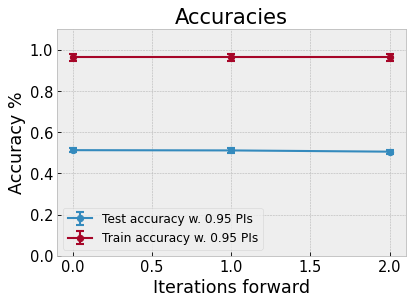

Test accuracies: [0.51250778 0.51122869 0.50516388]
Confusion matrices:


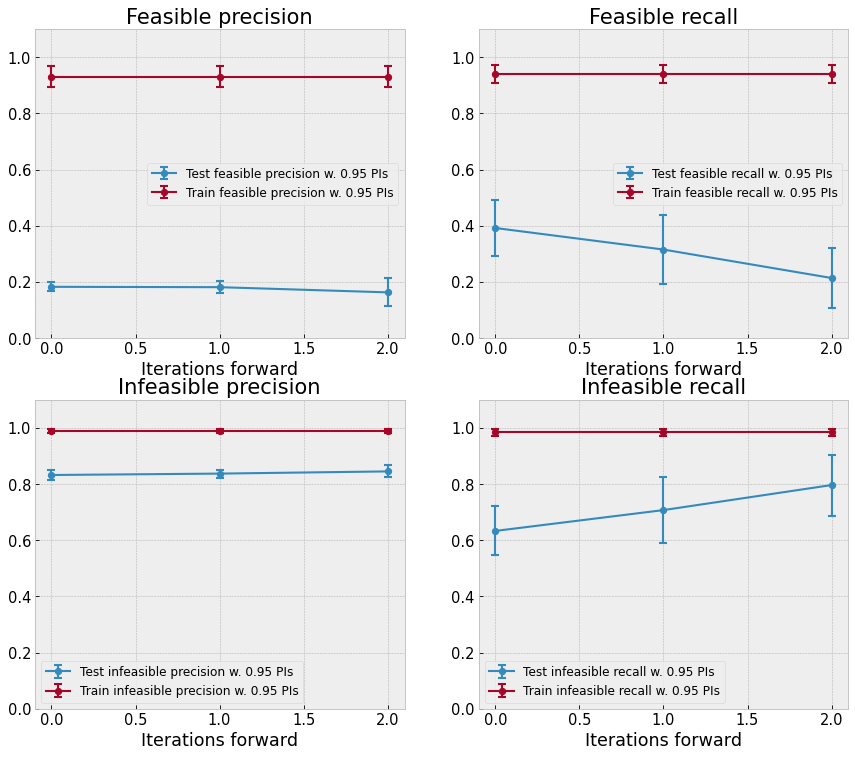

Percentage infeasible on test and train data:


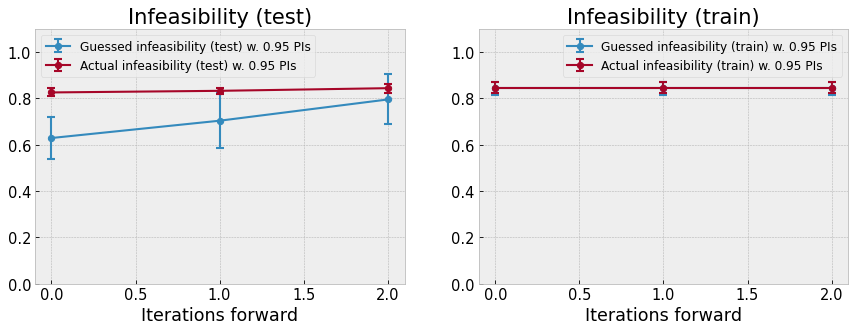

In [36]:
mt.plot_graphs(AUC = False)

# Conclusions

After some hyperparameter tuning we're able to achieve an average balanced accuracy of almost 52%. While this is better than some of our other models, it's not enough to warrant usage of the model. And we should remember, with all the hyperparameter tuning we do there is a chance that the 2 percentage points above random guessing is due to overfitting.

squared_hinge 51.3% > log (logistic regression) 50.5% > hinge (SVM) 50.4% 